In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import joblib

In [2]:
def save_theta(theta, filename="theta_final.joblib"):
    joblib.dump(theta, filename)
    print(f"Model saved to {filename}")

In [3]:
def load_theta(filename="theta_final.joblib"):
    theta = joblib.load(filename)
    print(f"Model loaded from {filename}")
    return theta

In [4]:
def train_test_split(X, y, test_size=0.2, random_state=None):
    np.random.seed(random_state)
    data_size = X.shape[0]
    indices = np.random.permutation(data_size)
    test_set_size = int(test_size * data_size)
    
    # Chia tập dữ liệu thành training và test
    test_indices = indices[:test_set_size]
    train_indices = indices[test_set_size:]
    
    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]
    
    return X_train, X_test, y_train, y_test

In [5]:
def calculate_mean_std(X):
    # Số lượng phần tử
    N = X.shape[0]
    
    # Tính mean cho từng cột
    mean = np.sum(X, axis=0) / N
    
    # Tính std cho từng cột
    variance = np.sum((X - mean) ** 2, axis=0) / N
    std = np.sqrt(variance)
    
    return mean, std

In [6]:
def standardize_data(X_train, X_test):
    # Tính mean và std từ X_train
    mean_X_train, std_X_train = calculate_mean_std(X_train)
    
    # Tránh chia cho 0 nếu std bằng 0
    for i in range(len(std_X_train)):
        if std_X_train[i] == 0:
            std_X_train[i] = 1.0
    
    # Chuẩn hóa dữ liệu
    X_train_scaled = (X_train - mean_X_train) / std_X_train
    X_test_scaled = (X_test - mean_X_train) / std_X_train
    
    return X_train_scaled, X_test_scaled

In [7]:
def sigmoid(z):
    # z = np.clip(z, -500, 500)  # Giới hạn z để tránh overflow
    return 1 / (1 + np.exp(-z))

In [8]:
def cal_loss(h, y):
    epsilon = 1e-15
    h = np.clip(h, epsilon, 1 - epsilon)
    m = y.shape[0]
    return -1 / m * np.sum(y * np.log(h) + (1 - y) * np.log(1 - h))

In [9]:
def gradient_descent(X, y, theta, learning_rate, n_loop, tolerance=1e-4, patience=10):
    m = X.shape[0]
    losses = []
    no_improve_count = 0  # Đếm số vòng không có cải thiện đáng kể
    
    for i in range(n_loop):
        z = np.dot(X, theta)
        h = sigmoid(z)
        err = h - y
        grad = (1 / m) * np.dot(X.T, err)
        theta = theta - learning_rate * grad
        loss = cal_loss(h, y)
        losses.append(loss)
        
        # Kiểm tra dừng sớm sau khi đủ ít nhất 1 loss
        if i > 0:
            loss_change = abs(losses[-2] - loss)
            if loss_change < tolerance:  # Nếu thay đổi nhỏ hơn ngưỡng
                no_improve_count += 1
            else:
                no_improve_count = 0  # Reset nếu có cải thiện
            
            if no_improve_count >= patience:  # Nếu vượt quá patience
                print(f"Early stopping at iteration {i}. Loss = {loss:.4f}")
                break
        
        if i % 50 == 0:
            print(f"Iteration {i}: Loss = {loss:.4f}")
    save_theta(theta)
        
    return theta, losses

In [10]:
def confusion_matrix(y_true, y_pred):
    # Khởi tạo các biến đếm
    TP = 0  # True Positive
    TN = 0  # True Negative
    FP = 0  # False Positive
    FN = 0  # False Negative
    
    # Duyệt qua từng cặp (y_true, y_pred)
    for true, pred in zip(y_true, y_pred):
        if true == 1 and pred == 1:
            TP += 1
        elif true == 0 and pred == 0:
            TN += 1
        elif true == 0 and pred == 1:
            FP += 1
        elif true == 1 and pred == 0:
            FN += 1
    
    # Trả về kết quả dưới dạng dictionary
    return {"TP": TP, "TN": TN, "FP": FP, "FN": FN}

In [11]:
def accuracy(y_true, y_pred):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()

    TP = sum((y_true == 1) & (y_pred == 1))
    TN = sum((y_true == 0) & (y_pred == 0))
    
    accuracy = (TP + TN) / len(y_true)
    return accuracy

In [12]:
def precision(y_true, y_pred):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    TP = sum((y_true == 1) & (y_pred == 1))
    FP = sum((y_true == 0) & (y_pred == 1))
    
    if TP + FP == 0:  # Tránh chia cho 0
        return 0
    precision = TP / (TP + FP)
    return precision

In [13]:
def recall(y_true, y_pred):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    TP = sum((y_true == 1) & (y_pred == 1))
    FN = sum((y_true == 1) & (y_pred == 0))

    positive = sum(y_true == 1)
    if TP + FN == 0:  # Tránh chia cho 0
        return 0
    recall = TP / (TP + FN)
    return recall, TP, positive

In [14]:
def f1_score(y_true, y_pred):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    prec = precision(y_true, y_pred)
    rec, TP, positive = recall(y_true, y_pred)
    
    if prec + rec == 0:  # Tránh chia cho 0
        return 0
    f1 = 2 * (prec * rec) / (prec + rec)
    return f1

In [15]:
def predict(X, theta, threshold=0.5):
    # Tính giá trị xác suất dự đoán bằng sigmoid
    z = np.dot(X, theta)
    h = sigmoid(z)
    
    # Chuyển đổi xác suất thành nhãn dự đoán
    y_pred = (h >= threshold).astype(int)
    return y_pred

Import dataset

In [16]:
import pandas as pd
data = pd.read_csv('data.csv')

In [17]:
data

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,NaN
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,NaN
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,NaN
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,NaN


In [18]:
data = data.drop('id', axis=1)

In [19]:
data = data.drop('Unnamed: 32', axis=1)

In [20]:
data.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

In [22]:
data.tail()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
564,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400
568,B,7.76,24.54,47.92,181.0,0.05263,0.04362,0.00000,0.00000,0.1587,...,9.456,30.37,59.16,268.6,0.08996,0.06444,0.0000,0.0000,0.2871,0.07039


In [23]:
label_counts = data['diagnosis'].value_counts()

In [24]:
label_counts

diagnosis
B    357
M    212
Name: count, dtype: int64

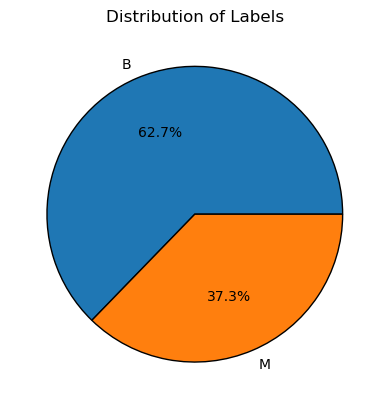

In [25]:
plt.pie(label_counts, labels = label_counts.index, wedgeprops={'edgecolor':'black'}, autopct='%1.1f%%')
plt.title('Distribution of Labels')
plt.show()

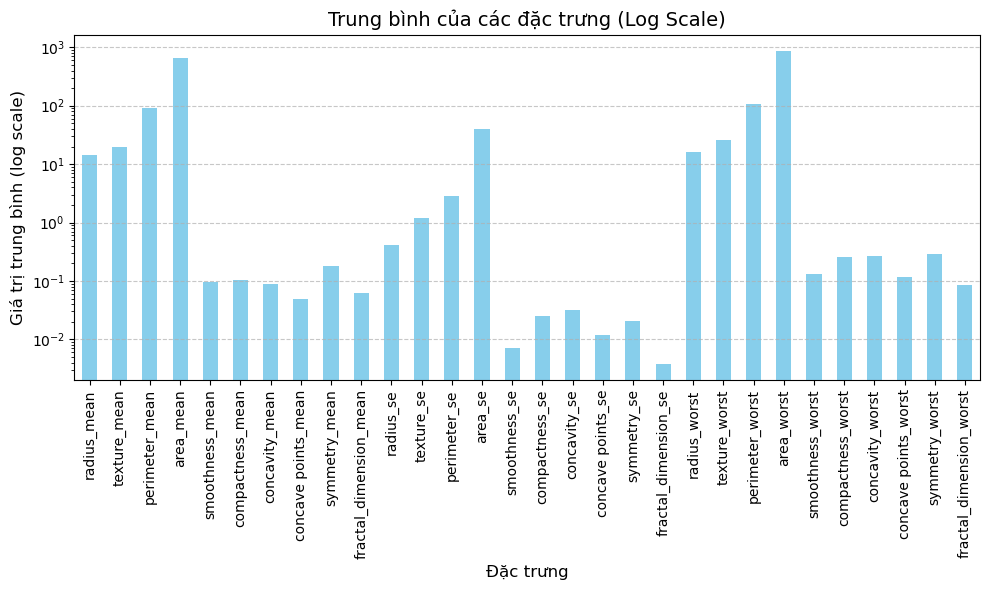

In [40]:
# Tính trung bình của từng đặc trưng
feature_means = data.drop(columns=['diagnosis']).mean()  # Bỏ cột nhãn (label)

# Vẽ biểu đồ cột với trục y theo log scale
plt.figure(figsize=(10, 6))
feature_means.plot(kind='bar', color='skyblue')
plt.title('Trung bình của các đặc trưng (Log Scale)', fontsize=14)
plt.ylabel('Giá trị trung bình (log scale)', fontsize=12)
plt.xlabel('Đặc trưng', fontsize=12)
plt.yscale('log')  # Áp dụng log scale
plt.xticks(rotation=90, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


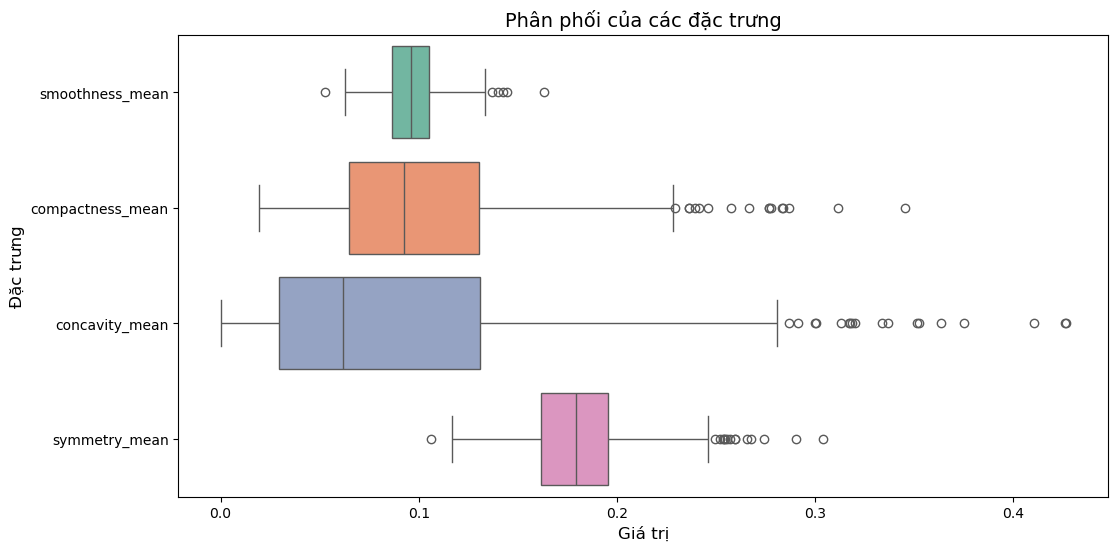

In [27]:
# Chọn một số đặc trưng quan trọng để vẽ
features_to_plot = ['smoothness_mean', 'compactness_mean', 'concavity_mean', 'symmetry_mean']
# Vẽ box plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=data[features_to_plot], orient='h', palette='Set2')
plt.title('Phân phối của các đặc trưng', fontsize=14)
plt.xlabel('Giá trị', fontsize=12)
plt.ylabel('Đặc trưng', fontsize=12)
plt.show()

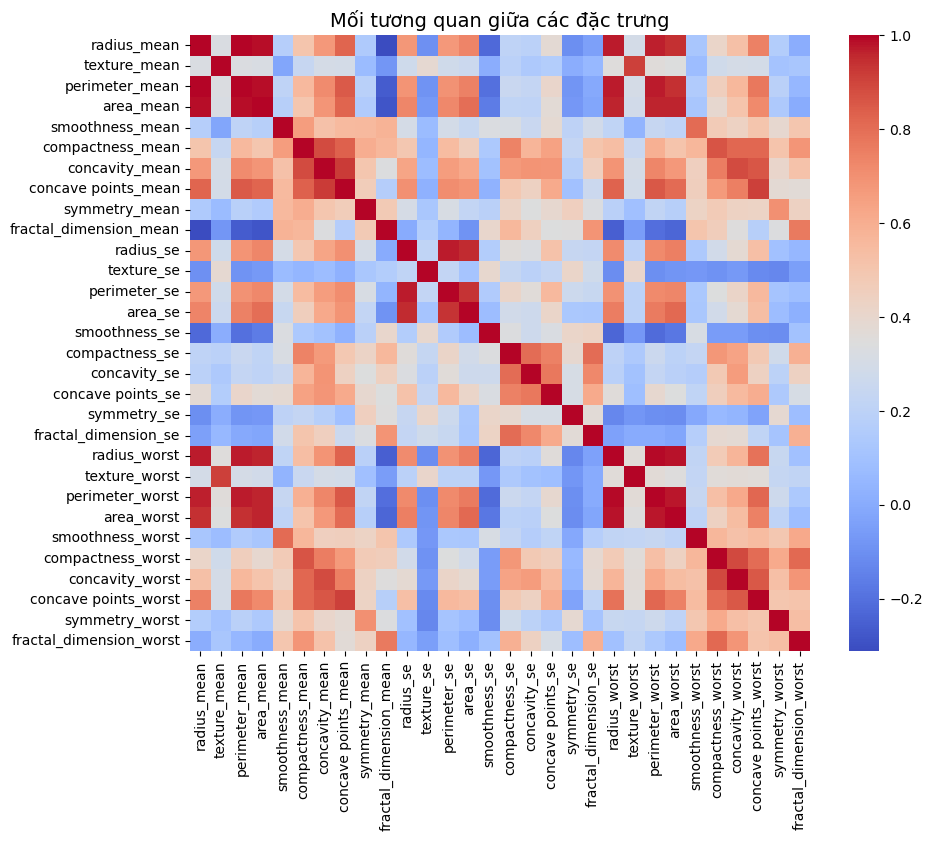

In [28]:
# Loại bỏ cột 'diagnosis' trước khi tính toán ma trận tương quan
correlation_matrix = data.drop(columns=['diagnosis']).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Mối tương quan giữa các đặc trưng', fontsize=14)
plt.show()


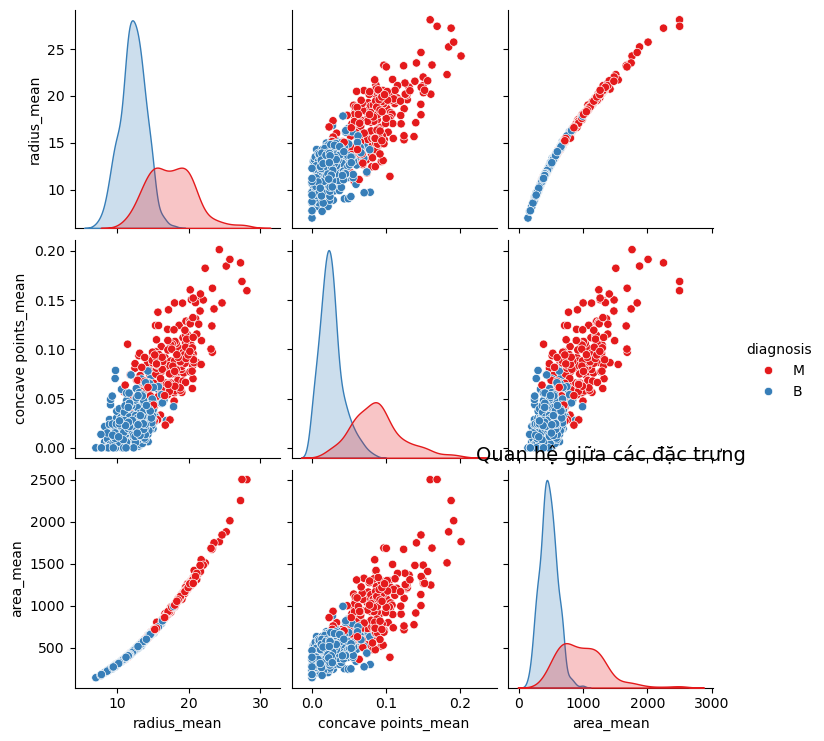

In [55]:
sns.pairplot(data, vars=['radius_mean', 'concave points_mean', 'area_mean'], hue='diagnosis', palette='Set1')
plt.title('Quan hệ giữa các đặc trưng', fontsize=14)
plt.show()

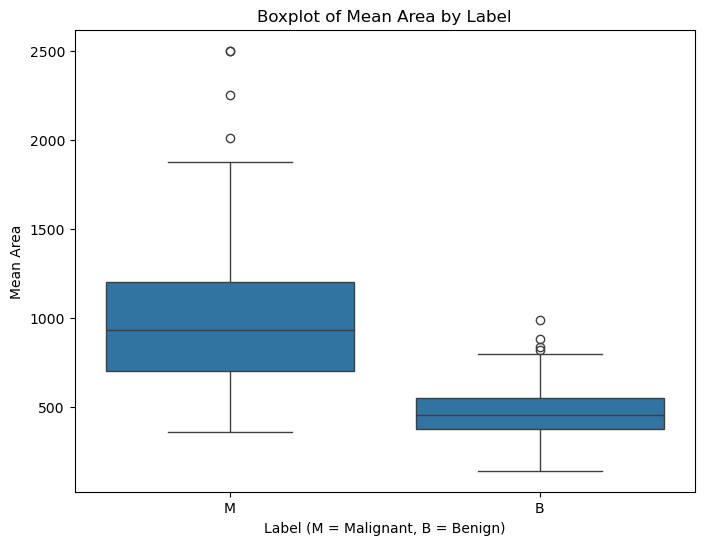

In [43]:
# Vẽ biểu đồ hộp cho một đặc trưng cụ thể (ví dụ: 'mean area')
plt.figure(figsize=(8, 6))
sns.boxplot(x='diagnosis', y='area_mean', data=data)
plt.title('Boxplot of Mean Area by Label')
plt.xlabel('Label (M = Malignant, B = Benign)')
plt.ylabel('Mean Area')
plt.show()

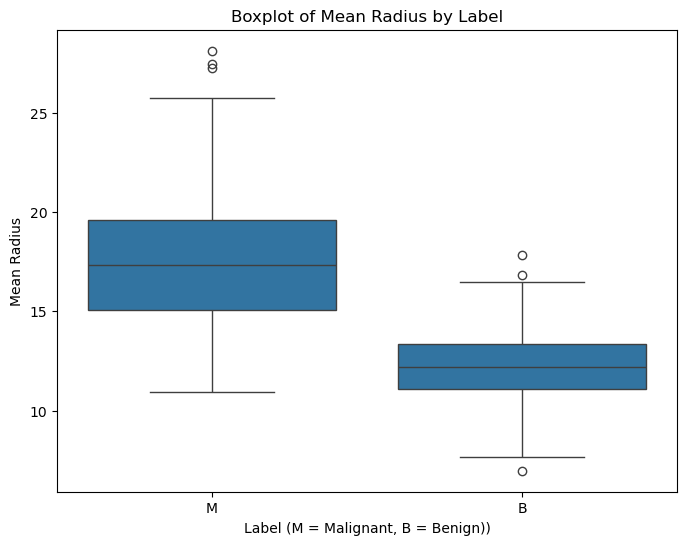

In [44]:
# Vẽ biểu đồ hộp cho một đặc trưng cụ thể (ví dụ: 'mean area')
plt.figure(figsize=(8, 6))
sns.boxplot(x='diagnosis', y='radius_mean', data=data)
plt.title('Boxplot of Mean Radius by Label')
plt.xlabel('Label (M = Malignant, B = Benign))')
plt.ylabel('Mean Radius')
plt.show()

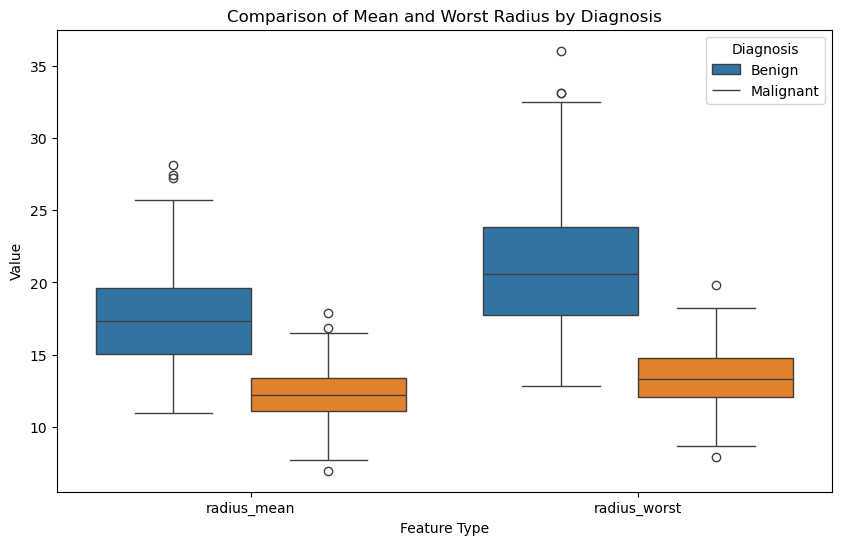

In [45]:
# Lấy dữ liệu từ cột 'radius_mean' và 'radius_worst' để so sánh
data_long = pd.melt(data[['diagnosis', 'radius_mean', 'radius_worst']], 
                    id_vars='diagnosis', 
                    var_name='Feature Type', 
                    value_name='Value')

# Vẽ boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Feature Type', y='Value', hue='diagnosis', data=data_long)
plt.title('Comparison of Mean and Worst Radius by Diagnosis')
plt.xlabel('Feature Type')
plt.ylabel('Value')
plt.legend(title='Diagnosis', labels=['Benign', 'Malignant'])
plt.show()


In [35]:
# Chuẩn bị dữ liệu
X = data.drop('diagnosis', axis=1).values
y = data['diagnosis'].map({'M': 1, 'B': 0}).values.reshape(-1, 1)        # Chuyển y về mảng cột

# Chia tập dữ liệu thành training và test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tính toán mean và std chỉ từ X_train
X_train, X_test = standardize_data(X_train, X_test)

# Khởi tạo các tham số và siêu tham số
learning_rate = 0.01
theta = np.zeros((X_train.shape[1], 1))  # Số chiều của theta phù hợp với số đặc trưng của X_train
n_loop = 1000

# Hàm huấn luyện Logistic Regression
theta_final, losses = gradient_descent(X_train, y_train, theta, learning_rate, n_loop)

# Dự đoán trên tập kiểm tra
y_pred_test = predict(X_test, theta_final)

# Đánh giá mô hình
conf_matrix = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix:", conf_matrix)

accuracy_test = accuracy(y_test, y_pred_test)

print("Độ chính xác trên tập kiểm tra:", accuracy_test)
precision_test = precision(y_test, y_pred_test)

print("Precision:", precision_test)
recall_test, TP, positive = recall(y_test, y_pred_test)
print('TP', TP)
print('Positive', positive)
print("Recall:", recall_test)

f1_test = f1_score(y_test, y_pred_test)

print("f1_test:", f1_test)

Iteration 0: Loss = 0.6931
Iteration 50: Loss = 0.3399
Iteration 100: Loss = 0.2604
Iteration 150: Loss = 0.2221
Iteration 200: Loss = 0.1984
Iteration 250: Loss = 0.1821
Iteration 300: Loss = 0.1699
Iteration 350: Loss = 0.1604
Iteration 400: Loss = 0.1527
Iteration 450: Loss = 0.1463
Iteration 500: Loss = 0.1409
Early stopping at iteration 508. Loss = 0.1402
Model saved to theta_final.joblib
Confusion Matrix: {'TP': 41, 'TN': 69, 'FP': 2, 'FN': 1}
Độ chính xác trên tập kiểm tra: 0.9734513274336283
Precision: 0.9534883720930233
TP 41
Positive 42
Recall: 0.9761904761904762
f1_test: 0.9647058823529412


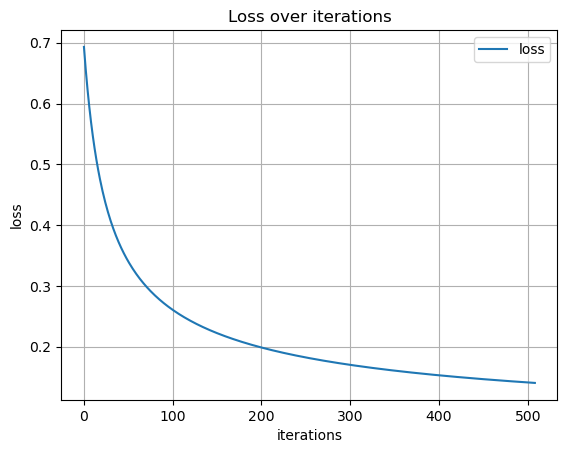

In [36]:
plt.plot(range(len(losses)), losses, label='loss')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('Loss over iterations')
plt.legend()
plt.grid()
plt.show()

In [37]:
# Chuẩn bị dữ liệu
X = data.drop('diagnosis', axis=1).values
y = data['diagnosis'].map({'M': 1, 'B': 0}).values.reshape(-1, 1)        # Chuyển y về mảng cột
# y = data['diagnosis'].values.reshape(-1, 1)        # Chuyển y về mảng cột

# Chia tập dữ liệu thành training và test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tính toán mean và std chỉ từ X_train
X_train, X_test = standardize_data(X_train, X_test)

# Thêm cột bias (cột toàn 1) vào X_train và X_test
X_train = np.hstack((np.ones((X_train.shape[0], 1)), X_train))
X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

# Khởi tạo các tham số và siêu tham số
learning_rate = 0.01
theta = np.zeros((X_train.shape[1], 1))  # Số chiều của theta phù hợp với số đặc trưng của X_train
n_loop = 1000

# Hàm huấn luyện Logistic Regression
theta_final, losses = gradient_descent(X_train, y_train, theta, learning_rate, n_loop)

# Dự đoán trên tập kiểm tra
y_pred_test = predict(X_test, theta_final)

conf_matrix = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix:", conf_matrix)

# Đánh giá mô hình
accuracy_test = accuracy(y_test, y_pred_test)

print("Độ chính xác trên tập kiểm tra:", accuracy_test)
precision_test = precision(y_test, y_pred_test)

print("Precision:", precision_test)
recall_test, TP, positive = recall(y_test, y_pred_test)
print('TP', TP)
print('Positive', positive)
print("Recall:", recall_test)

f1_test = f1_score(y_test, y_pred_test)

print("f1_test:", f1_test)

Iteration 0: Loss = 0.6931
Iteration 50: Loss = 0.3348
Iteration 100: Loss = 0.2539
Iteration 150: Loss = 0.2151
Iteration 200: Loss = 0.1914
Iteration 250: Loss = 0.1752
Iteration 300: Loss = 0.1631
Iteration 350: Loss = 0.1538
Iteration 400: Loss = 0.1463
Iteration 450: Loss = 0.1401
Early stopping at iteration 498. Loss = 0.1351
Model saved to theta_final.joblib
Confusion Matrix: {'TP': 41, 'TN': 70, 'FP': 1, 'FN': 1}
Độ chính xác trên tập kiểm tra: 0.9823008849557522
Precision: 0.9761904761904762
TP 41
Positive 42
Recall: 0.9761904761904762
f1_test: 0.9761904761904762


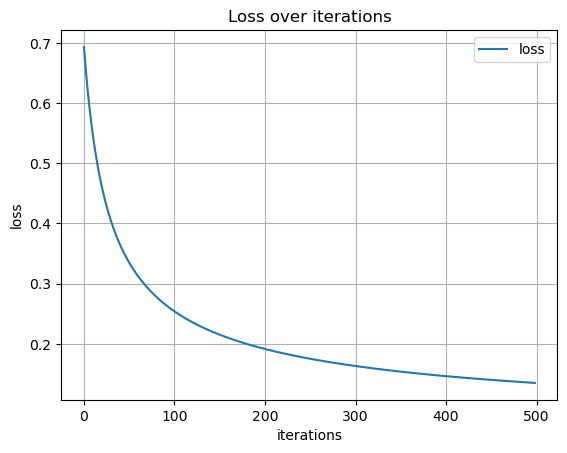

In [38]:
plt.plot(range(len(losses)), losses, label='loss')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('Loss over iterations')
plt.legend()
plt.grid()
plt.show()